In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [3]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 15.

In [4]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
print(f"Δt = {(ds['time'][-1] - ds['time'][0]).values*1e-9/(24*60*60)} days")
ds = ds.mean('time')
ds, grid = add_rotated_coords(ds, θ)

geo = xr.open_dataset(data_dir+"geocoords.nc")
ds['Depth_actual'] = xr.zeros_like(ds['Depth']) - geo['z_actual'].values

ds = add_thalweg(ds)
ds = add_background_temp(ds, Γ)

dx = 600.; dy = 600.;
Ly = ds.YC.size*dy
Lx = ds.XC.size*dx

Δt = 450 days


In [5]:
mx_mean_depth = (-ds['Depth'] + ds.attrs['H']).mean(dim='XC')
mx_min_depth = (-ds['Depth'] + ds.attrs['H']).min(dim='XC')

In [6]:
U = (ds['UVEL']*ds['drF']*ds['hFacW']).sum('Z').compute()
Ubot = (ds['UVEL']*ds['drF']*ds['hFacW']).sel(Z=ds['Z'][::-1].sel(Z=slice(0, 800))[::-1]).sum('Z').compute()
ds['Depthr'].load();

In [7]:
def format_yz_section(ax):
    ax.set_xlabel("cross-canyon distance [km]")
    ax.set_xticks(np.arange(0., 70e3, 10e3))
    ax.set_xticklabels(np.arange(0, 70, 10))
    ax.set_xlim([60e3, 0e3])
    ax.set_ylabel("height above mean-slope [m]")
    ax.set_title("")
    
def format_xz_section(ax):
    ax.set_xlabel("along-canyon distance [km]")
    xticks = np.arange(0, 500, 50)
    xticklabels = [str(x) if (i+1)%2 else '' for i, x in enumerate(xticks)]
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([0, 480e3])
    ax.set_ylabel("depth [m]")
    ax.set_title("")
    
def clean_long_plots(ax):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")

    xticks = np.arange(0, 500, 20)
    xticklabels = [str(x) if (i+1)%2 else '' for i, x in enumerate(xticks)]
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticklabels)

    yticks = np.arange(0, 80, 20)
    yticklabels = [str(x) for i, x in enumerate(yticks)]
    ax.set_yticks(yticks*1e3)
    ax.set_yticklabels(yticklabels)

In [8]:
ds.attrs['H_actual'] = ds['Depth_actual'].max().values
ds = ds.assign_coords({'Zr_actual': ds.attrs['H_actual'] - ds['Zr']})
ds = ds.assign_coords({'Zr_U_actual': ds.attrs['H_actual'] - ds['Zr_U']})

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


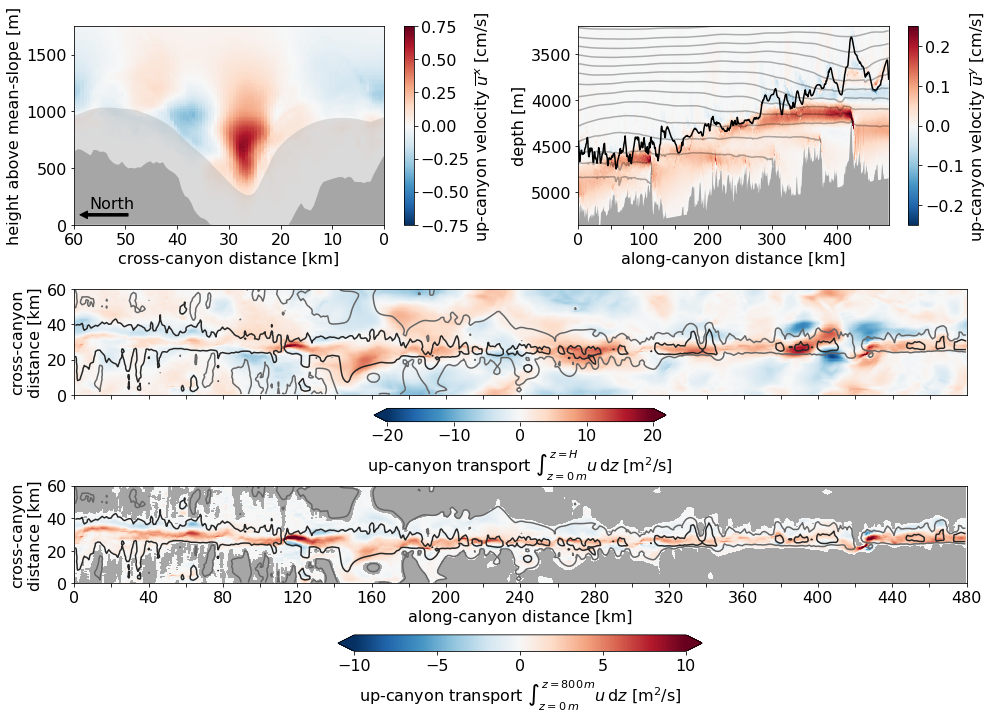

In [10]:
fig = plt.figure(figsize=(16,11.5))
fig_grid = plt.GridSpec(20, 2, wspace=0.3, hspace=20.)

ax = plt.subplot(fig_grid[0:7, 0])
q = (ds['UVEL']*100).mean(dim='XG', skipna=True).plot(ax=ax)
q.set_clim([-0.75, 0.75])
q.colorbar.set_label(r"up-canyon velocity $\overline{u}^{x}$ [cm/s]")
ax.fill_between((ds['YC']-dx*1.1)*1.0125, 0.*mx_mean_depth, mx_mean_depth, facecolor=nancol, alpha=0.35)
ax.fill_between((ds['YC']-dx*1.1)*1.0125, 0.*mx_min_depth, mx_min_depth, facecolor=nancol)
format_yz_section(ax)
ax.set_ylim([0, 1750])

arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='k')
ax.annotate(r"North", (0.05, 0.085), xycoords="axes fraction");
ax.annotate("", (0.02, 0.05), (0.175, 0.05), xycoords="axes fraction", arrowprops=arrowprops);

ax = plt.subplot(fig_grid[0:7, 1])
q = (ds['UVEL']*100).mean(dim='YC', skipna=True).plot(ax=ax, x='Xr_U', y='Zr_U_actual')
q.set_clim([-0.25, 0.25])
q.colorbar.set_label(r"up-canyon velocity $\overline{u}^{y}$ [cm/s]")
ds['THETA_BG'].where(ds['hFacC']!=0.).mean(dim=['YC'], skipna=True).plot.contour(x='Xr', y='Zr_actual', colors='k', linestyles="-", alpha=0.3, levels=np.arange(0.5, 3., 0.1))
subsampled = ds['THETA_BG'].where(ds['hFacC']!=0.).mean(dim=['YC'], skipna=True).isel(XC=np.append(np.arange(0,800,80), [799]))
#subsampled.plot.contour(x='Xr', y='Zr_actual', colors='k', linestyles="--", alpha=0.45, levels=np.arange(0.5, 3., 0.1))
crest_dep = irregular_section( ds.attrs['H_actual'] - (-ds['Depthr'] + ds.attrs['H']), ds['j_thalweg'].values, width=25, invert_mask=True)
crest_dep.mean(dim='YC', skipna=True).plot(ax=ax, color="k")
thalweg_dep = irregular_section( ds.attrs['H_actual'] - (-ds['Depthr'] + ds.attrs['H']), ds['j_thalweg'].values)
ax.fill_between(ds['XC'], thalweg_dep*0. + 6000, thalweg_dep, facecolor=nancol)
format_xz_section(ax)
ax.set_ylim([5350, 3200])

ax = plt.subplot(fig_grid[8:13, :])
clean_long_plots(ax)
ax.set_xticklabels([])
ax.set_xlabel("")
PC = U.plot(vmin=-20, vmax=20, cmap=div_cmap, cbar_kwargs={
    'orientation': 'horizontal',
    'label': r"up-canyon transport $\int^{z=H}_{z=0\, m} u \, $d$z$ [m$^{2}$/s]",
    'pad': 0.1,
    'fraction':0.1,
    'extend':'both'
})
Dep = ds['Depthr'].coarsen(dim={'XC': 2, 'YC':2}).mean()
Dep.plot.contour(levels=[1600, 2000], colors=[(0.4,0.4,0.4), (0.15, 0.15, 0.15)])
ax.set_ylabel("cross-canyon\ndistance [km]")
ax.set_xlabel("")

ax = plt.subplot(fig_grid[14:, :])
PC = Ubot.where(Ubot!=0.).plot(vmin=-10, vmax=10, cmap=div_cmap, cbar_kwargs={
    'orientation': 'horizontal',
    'label': r"up-canyon transport $\int^{z=800\, m}_{z=0\, m} u \, $d$z$ [m$^{2}$/s]",
    'pad': 0.31,
    'fraction':0.1,
    'extend':'both'
})
Dep = ds['Depthr'].coarsen(dim={'XC': 2, 'YC':2}).mean()
Dep.plot.contour(levels=[1600, 2000], colors=[(0.4,0.4,0.4), (0.15, 0.15, 0.15)])
# What are these isobaths?
clean_long_plots(ax)
ax.set_ylabel("cross-canyon\ndistance [km]")
ax.set_xlabel("along-canyon distance [km]");

plt.savefig("../../figures/BBTRE/meanflow.png", dpi=100., bbox_inches='tight')

In [70]:
geo = xr.open_dataset(data_dir+"geocoords.nc").drop(["X", "Y"])
moorings = {
    "CTS17-P1": {'coords': (-14.58, -21.12)},
    "CTS17-P2": {'coords': (-14.59, -21.10)},
    "T05": {'coords': (-17.-48.5/60., -21.-36.9/60.)}
}

In [71]:
lons = [mooring['coords'][0] for mooring in moorings.values()]
lats = [mooring['coords'][1] for mooring in moorings.values()]
samples = sample_locations(geo, lons, lats)
samples['sample_shift'] = [-3, 0, 4]

In [72]:
mooring_data = 1.

In [73]:
import pandas as pd

###
T05 = pd.read_csv("../../data/Thurnherr2005.csv")

T05_vel_conversion = np.float(T05["1 cm/s reference"][1]) - np.float(T05["1 cm/s reference"][2]) # ºlon per 1 cm/s
T05_vel = np.array([
    np.float(T05["Current Meter #7"][1]) - np.float(T05["Current Meter #7"][2]),
    np.float(T05["Current Meter #6"][1]) - np.float(T05["Current Meter #6"][2]),
    np.float(T05["Current Meter #5"][1]) - np.float(T05["Current Meter #5"][2])
]) / T05_vel_conversion

T05_dep = np.array([
    np.float(T05["Unnamed: 4"][1]),
    np.float(T05["Unnamed: 7"][1]),
    np.float(T05["Unnamed: 10"][1])
])

T05_bot = np.float(T05["Bottom"][1])

### 
C17 = pd.read_csv("../../data/Clement2017.csv")
C17.head()

C17_vel = np.append(np.array((C17['Current Meters'][1:]).astype("float64")), np.array((C17['VMP'][1:]).astype("float64")))
C17_vel = np.append(np.array([0.]), C17_vel)
C17_dep = np.append(np.array((C17['Unnamed: 1'][1:]).astype("float64")), np.array((C17['Unnamed: 3'][1:]).astype("float64")))
C17_dep = np.append(np.array([np.float(np.nanmax(C17_dep))+2.5]), C17_dep)

C17_MMP_vel = np.array((C17['Current Meters'][1:]).astype("float64"))
C17_MMP_dep = np.array((C17['Unnamed: 1'][1:]).astype("float64"))
idx = np.argsort(C17_MMP_dep)
C17_MMP_vel = C17_MMP_vel[idx][1:-2]
C17_MMP_dep = C17_MMP_dep[idx][1:-2]

idx = np.argsort(C17_dep)
C17_vel = C17_vel[idx]
C17_dep = C17_dep[idx]

In [77]:
budg = open_mdsdataset(data_dir, ignore_unknown_vars=True, prefix=["budgetDiag"], delta_t=delta_t)
n = 0
u_quants_C17 = (budg['UVEL']*100).isel(XG=samples['i'][n], YC=samples['j'][n]+samples["sample_shift"][n]).chunk({'time': -1}).quantile([0.1, 0.9], dim="time").compute()
n = 2
u_quants_T05 = (budg['UVEL']*100).isel(XG=samples['i'][n], YC=samples['j'][n]+samples["sample_shift"][n]).chunk({'time': -1}).quantile([0.1, 0.9], dim="time").compute()

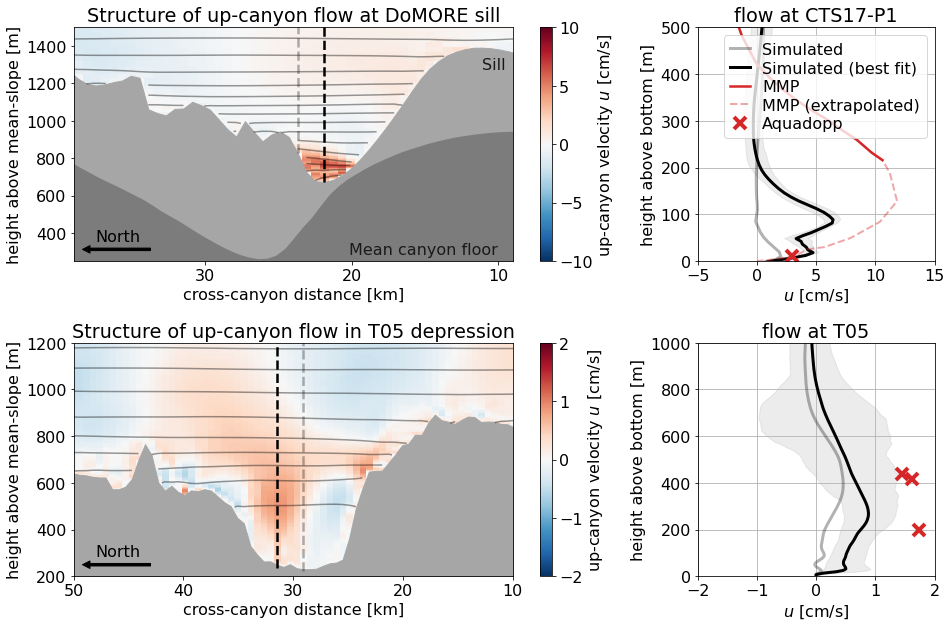

In [78]:
####
n = 0
i = samples['i'][n]
j = samples['j'][n]

fig = plt.figure(figsize=(13.5,9))
gs = fig.add_gridspec(2, 3)

##
ax = fig.add_subplot(gs[:1, :2])
q = (ds['UVEL']*100).isel(XG=i).plot(ax=ax)
q.set_clim([-10, 10])
q.colorbar.set_label(r"up-canyon velocity $u$ [cm/s]")
ds['THETA_BG'].isel(XC=[i, i-1]).mean('XC', skipna=False).plot.contour(ax=ax, colors='k', levels=np.arange(0., 3.0, 0.05), alpha=0.4)
format_yz_section(ax)
ax.set_title("Structure of up-canyon flow at DoMORE sill")
ax.set_ylim([250, 1500])

sec_depth = (-ds['Depth']+ds.attrs['H']).isel(XC=[i, i-1]).max('XC')
ax.fill_between(ds['YC'], 0.*sec_depth, sec_depth, color=nancol)
YC_sample = ds['YC'][j]
ax.plot([YC_sample, YC_sample], [830., 1800.], "k--", alpha=0.3,  lw=2.5)
ax.set_xlim(39e3, 9e3)
ax.fill_between((ds['YC']-dx*1.1)*1.0125, 0.*mx_mean_depth, mx_mean_depth, facecolor='k', alpha=0.25)
ax.annotate("Sill", (0.93, 0.82), color=(0.1, 0.1, 0.1), xycoords='axes fraction')
ax.annotate("Mean canyon floor", (0.628, 0.03), color=(0.1, 0.1, 0.1), xycoords='axes fraction')

YC_sample = ds['YC'][j+samples["sample_shift"][n]]
ax.plot([YC_sample, YC_sample], [675., 1800.], "k--", lw=2.5)

arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='k')
ax.annotate(r"North", (0.05, 0.085), xycoords="axes fraction");
ax.annotate("", (0.02, 0.05), (0.175, 0.05), xycoords="axes fraction", arrowprops=arrowprops);

##
ax = fig.add_subplot(gs[:1, 2:])

ds = ds.assign_coords({"Zhab": ds['Z']-675.})
plt.fill_betweenx(ds.Zhab, u_quants_C17.isel(quantile=0), u_quants_C17.isel(quantile=1), alpha=0.15, color="grey")

ds = ds.assign_coords({"Zhab": ds['Z']-830.})
(ds['UVEL']*100).isel(XG=i, YC=j).plot(y='Zhab', color="k", lw=3, alpha=0.3, label="Simulated")
ds = ds.assign_coords({"Zhab": ds['Z']-675.})
(ds['UVEL']*100).isel(XG=i, YC=j+samples["sample_shift"][n]).plot(y='Zhab', color="k", lw=3, label="Simulated (best fit)")
plt.plot(C17_MMP_vel, np.nanmax(C17_dep) - C17_MMP_dep, '-', color="C3",label="MMP", linewidth=2.5)
plt.plot(C17_vel, np.nanmax(C17_dep) - C17_dep, '--', color="C3",label="MMP (extrapolated)", alpha=0.4, linewidth=2)
plt.plot([3.], [10], 'x', markeredgewidth=4, markersize=12, color="C3",label="Aquadopp")
plt.ylim([0., 500.])
plt.xlim([-5, 15])
plt.title("flow at CTS17-P1")
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$u$ [cm/s]")
plt.grid(True)
plt.legend(labelspacing=0.23, handlelength=1.2)

####
n = 2
i = samples['i'][n]
j = samples['j'][n]

##
ax = fig.add_subplot(gs[1:, :2])
q = (ds['UVEL']*100).isel(XG=i).plot(ax=ax)
q.set_clim([-2, 2])
q.colorbar.set_label(r"up-canyon velocity $u$ [cm/s]")
ds['THETA_BG'].isel(XC=[i, i-1]).mean('XC', skipna=False).plot.contour(ax=ax, colors='k', levels=np.arange(0., 3.0, 0.05), alpha=0.4)
format_yz_section(ax)
ax.set_title("Structure of up-canyon flow in T05 depression")
ax.set_ylim([200, 1200])

sec_depth = (-ds['Depth']+ds.attrs['H']).isel(XC=[i, i-1]).max('XC')
ax.fill_between(ds['YC'], 0.*sec_depth, sec_depth, color=nancol)
YC_sample = ds['YC'][j]
ax.plot([YC_sample, YC_sample], [225., 1800.], "k--",  alpha=0.3, lw=2.5)
ax.set_xlim(50e3, 10e3)

YC_sample = ds['YC'][j+samples["sample_shift"][n]]
ax.plot([YC_sample, YC_sample], [235., 1800.], "k--", lw=2.5)

arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='k')
ax.annotate(r"North", (0.05, 0.085), xycoords="axes fraction");
ax.annotate("", (0.02, 0.05), (0.175, 0.05), xycoords="axes fraction", arrowprops=arrowprops);

##
ax = fig.add_subplot(gs[1:, 2:])

ds = ds.assign_coords({"Zhab": ds['Z']-235.})
plt.fill_betweenx(ds.Zhab, u_quants_T05.isel(quantile=0), u_quants_T05.isel(quantile=1), alpha=0.15, color="grey")

ds = ds.assign_coords({"Zhab": ds['Z']-225.})
(ds['UVEL']*100).isel(XG=i, YC=j).plot(y='Zhab', color="k", alpha=0.3, lw=3)
ds = ds.assign_coords({"Zhab": ds['Z']-235.})
(ds['UVEL']*100).isel(XG=i, YC=j+samples["sample_shift"][n]).plot(y='Zhab', color="k", lw=3)

plt.plot(T05_vel, T05_bot - T05_dep, 'x', markeredgewidth=4, markersize=12, color="C3")
plt.ylim([0., 1000.])
plt.xlim([-2, 2])
plt.title("flow at T05")
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$u$ [cm/s]")
plt.grid(True)

plt.tight_layout()
plt.savefig("../../figures/BBTRE/simulated_moorings.png", dpi=100., bbox_inches='tight')

### Relative vorticity

In [13]:
k_lev = [32, 55, 73, 100]
snap = open_mdsdataset(data_dir, iters=7488000, ignore_unknown_vars=True, levels=k_lev, prefix=["levelDiag"], delta_t=delta_t, read_grid=False)
snap = snap.isel(time=0)
snap = snap.rename_dims({
    "i": "XC", "i_g": "XG",
    "j": "YC", "j_g": "YG",
    "k": "Z", "k_u": "Zu", "k_l": "Zl", "k_p1": "Zp1"
})
snap = snap.assign_coords(ds.isel(Z=k_lev, Zp1=np.append(k_lev, k_lev[-1]+1), Zu=k_lev, Zl=k_lev).coords)

In [14]:
ζ = grid.interp(grid.interp((-grid.diff(snap.UVEL * snap.dxC, 'Y', boundary='extend')
     +grid.diff(snap.VVEL * snap.dyC, 'X', boundary='extend'))/snap.rAz,
'X'), 'Y')
ζ.name = 'relative vorticity'
ζ = ζ.where(snap.hFacC != 0.)

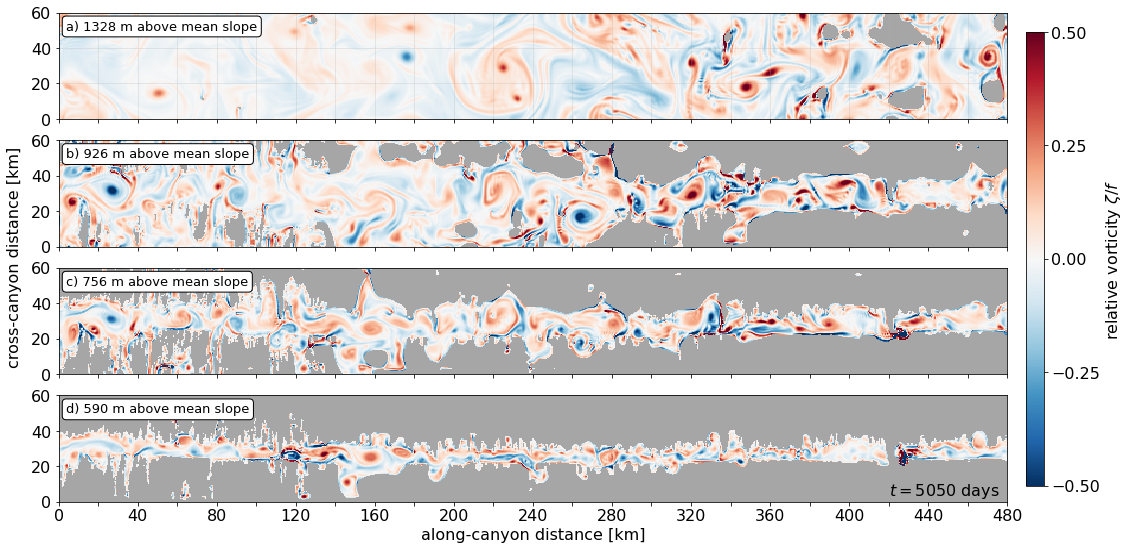

In [15]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(17,9))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("along-canyon distance [km]")
plt.ylabel("cross-canyon distance [km]")

labels = ["a)", "b)", "c)", "d)"]
for i in range(4):
    ax = axes[i]
    PC = (ζ/f).isel(Z=i).plot(ax=ax, cmap=div_cmap, vmin=-0.5, vmax=0.5)
    PC.colorbar.remove()
    clean_long_plots(ax)
    hab = np.int(snap['Z'].isel(Z=i).values)
    ax.set_title(
        label=f"{labels[i]} {hab} m above mean slope", loc='left',
        y=0.78, x=0.008, fontsize=13, color='k',
        bbox=dict(boxstyle="round",
            ec="k",
            fc="w",
        )
    )
    if i==0:
        ax.grid(True, alpha=0.3)
    if i==3:
        ax.annotate(r"$t=5050$ days", (0.875, 0.06), xycoords="axes fraction")
    
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.915, 0.15, 0.015, 0.7])
fig.colorbar(PC, cax=cbar_ax, ticks=[-0.5, -0.25, 0, 0.25, 0.5], label=r"relative vorticity $\zeta / f$")

plt.savefig("../../figures/BBTRE/vorticity_field.png", dpi=150., bbox_inches='tight')

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'evelation [m]')

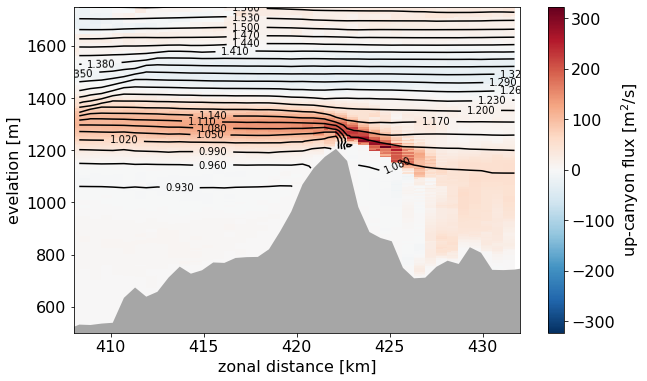

In [90]:
PC = (ds['UVEL']*dx).where(ds['UVEL']!=0.).isel(XG=slice(680, 720)).sum(dim='YC', skipna=True).plot(x='Xr_U', y='Zr_U')
PC.colorbar.set_label(r"up-canyon transport [m$^{2}$/s]")
CS = ds['THETA_BG'].isel(XC=slice(680, 720)).mean("YC", skipna=True).plot.contour(colors="k", levels=np.arange(0., 3., 0.03), x="Xr", y="Zr")
plt.clabel(CS, inline=1, fontsize=10)

plt.fill_between(ds['XC'], thalweg_dep*0., thalweg_dep, facecolor=nancol)
plt.xlim(ds['XG'].isel(XG=680), ds['XG'].isel(XG=720))
plt.ylim([500, 1750])
xticks = np.arange(410, 435, 5)
plt.xticks(xticks*1e3, xticks)
plt.xlabel("zonal distance [km]")
plt.ylabel("evelation [m]")

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


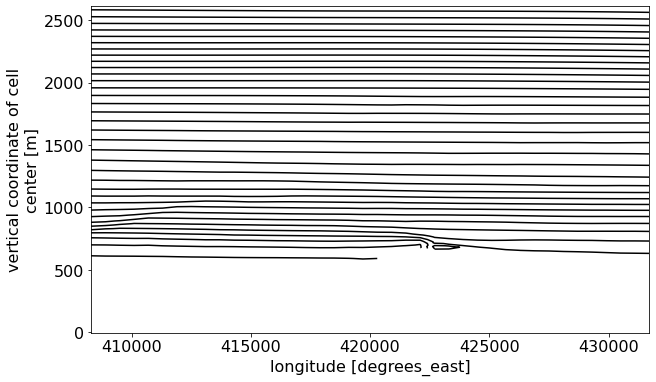

In [76]:
ds['THETA_BG'].isel(XC=slice(680, 720)).mean("YC", skipna=True).plot.contour(colors="k", levels=np.arange(0., 3., 0.05))

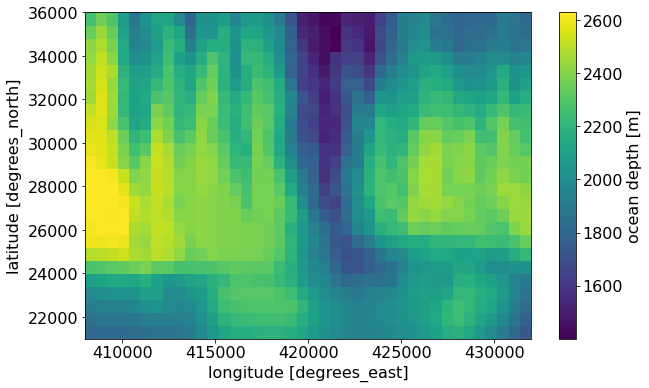

In [41]:
ds['Depth'].isel(XC=slice(680, 720), YC=slice(35, )).plot()